# LSHRS Demo 1: Basic LSH Operations

## Overview

This notebook demonstrates the fundamental capabilities of `lshrs` without external dependencies.
We'll explore:

- **LSH Configuration**: Understanding the band/row trade-off
- **Vector Ingestion**: Hashing and storing vectors in Redis buckets
- **Similarity Search**: Retrieving candidates and understanding collision probability
- **Hash Distribution**: Visual analysis of bucket population

### Key Concepts

**Locality Sensitive Hashing (LSH)** works by:
1. Projecting vectors onto random hyperplanes
2. Creating binary signatures (1 if projection > 0, else 0)
3. Storing vectors in buckets based on their signatures
4. During search, retrieving all vectors from matching buckets

**Band Configuration**:
- More bands = Higher recall (find more similar pairs) but lower precision
- More rows per band = Higher precision but lower recall
- `num_bands × rows_per_band = total_hash_bits`

In [1]:
# Standard imports
import numpy as np
import time
import matplotlib.pyplot as plt
from typing import List, Tuple

# LSHRS
from lshrs import LSHRS

# Configuration
REDIS_HOST = "localhost"
REDIS_PORT = 6379
DIM = 768  # Vector dimensionality
SEED = 42  # Reproducibility
HYPERPLANE_COUNT = 2**15

print("✓ Imports successful")

✓ Imports successful


## Section 1: Configuration & Auto-Tuning

LSHRS automatically calculates the optimal number of bands and rows per band
based on your target similarity threshold. Let's explore how this works.

## Section 2: Generating Test Data

We'll create three types of vectors to test retrieval:
1. **Anchor Vector**: Our query reference
2. **Similar Vectors**: Created by adding small noise to the anchor
3. **Dissimilar Vectors**: Completely random, unrelated vectors

In [2]:
# Initialize fresh LSH instance
lsh = LSHRS(
    dim=DIM,
    num_perm=HYPERPLANE_COUNT,
    similarity_threshold=0.5,
    redis_host=REDIS_HOST,
    redis_port=REDIS_PORT,
    redis_prefix="demo_basic",
    seed=SEED,
)

lsh.clear()
print("✓ LSH Initialized")
print(f"  Bands: {lsh.stats()['num_bands']}")
print(f"  Rows per Band: {lsh.stats()['rows_per_band']}")
print(f"  Vector Dimension: {lsh.stats()['dimension']}")
print(lsh.stats())

# Create anchor vector
np.random.seed(SEED)
anchor_vector = np.random.randn(DIM).astype(np.float32)

# Create similar vectors (anchor + small noise)
num_similar = 50_000
similar_vectors = []
for i in range(num_similar):
    noise = np.random.normal(0, 0.10, DIM).astype(np.float32)  # Small noise
    similar_vectors.append(anchor_vector + noise)

# Create dissimilar vectors (completely random)
num_dissimilar = 100_000
dissimilar_vectors = [
    np.random.randn(DIM).astype(np.float32) for _ in range(num_dissimilar)
]

print("\n✓ Data Generated")
print("  Anchor: 1 vector")
print(f"  Similar: {num_similar} vectors")
print(f"  Dissimilar: {num_dissimilar} vectors")
print(f"  Total: {1 + num_similar + num_dissimilar} vectors")

✓ LSH Initialized
  Bands: 128
  Rows per Band: 256
  Vector Dimension: 768
{'dimension': 768, 'num_perm': 32768, 'num_bands': 128, 'rows_per_band': 256, 'buffer_size': 10000, 'similarity_threshold': 0.5, 'redis_prefix': 'demo_basic'}

✓ Data Generated
  Anchor: 1 vector
  Similar: 50000 vectors
  Dissimilar: 100000 vectors
  Total: 150001 vectors


## Section 3: Ingestion & Bucket Population

We'll ingest vectors into Redis and observe how they're distributed across buckets.

In [3]:
# Ingest anchor vector
anchor_id = 0
lsh.ingest(anchor_id, anchor_vector)

# Ingest similar vectors
similar_ids = list(range(1, num_similar + 1))
for idx, vec in zip(similar_ids, similar_vectors):
    lsh.ingest(idx, vec)

# Ingest dissimilar vectors
dissimilar_ids = list(range(num_similar + 1, num_similar + num_dissimilar + 1))
for idx, vec in zip(dissimilar_ids, dissimilar_vectors):
    lsh.ingest(idx, vec)

print("✓ Ingestion Complete")
print(f"  Total vectors indexed: {1 + num_similar + num_dissimilar}")

✓ Ingestion Complete
  Total vectors indexed: 150001


## Section 4: Query & Retrieval

Now we query the index and analyze what candidates we retrieve.

In [4]:
# Execute query
start_time = time.time()
candidates = lsh.get_top_k(anchor_vector, topk=30)
query_time = (time.time() - start_time) * 1000  # ms

print(f"✓ Query Executed in {query_time:.2f}ms")
print("\nTop 30 Candidates:")
print("-" * 50)

# Categorize results
anchor_retrieved = anchor_id in candidates
similar_retrieved = sum(1 for c in candidates if c in similar_ids)
dissimilar_retrieved = sum(1 for c in candidates if c in dissimilar_ids)

print(f"Anchor (ID {anchor_id}): {'✓ Found' if anchor_retrieved else '✗ Not Found'}")
print(f"Similar Vectors: {similar_retrieved}/{num_similar} found ({100*similar_retrieved/num_similar:.1f}%)")
print(f"Dissimilar Vectors: {dissimilar_retrieved}/{num_dissimilar} found ({100*dissimilar_retrieved/num_dissimilar:.1f}%)")
print(f"\nCandidates: {candidates}")

✓ Query Executed in 66.20ms

Top 30 Candidates:
--------------------------------------------------
Anchor (ID 0): ✓ Found
Similar Vectors: 29/50000 found (0.1%)
Dissimilar Vectors: 0/100000 found (0.0%)

Candidates: [0, 4633, 4728, 9824, 10202, 10382, 18220, 19628, 23341, 25817, 27297, 27423, 32175, 33923, 38065, 39269, 39897, 40713, 42206, 45067, 15, 29, 47, 117, 133, 157, 180, 192, 261, 268]


## Section 5: Collision Analysis

Analyze the distribution of collisions and understand recall/precision trade-offs.

In [5]:
# Calculate metrics
total_candidates = len(candidates)
true_positives = similar_retrieved + (1 if anchor_retrieved else 0)
false_positives = dissimilar_retrieved

# Recall: Of all similar items, how many did we find?
recall = true_positives / (1 + num_similar) if (1 + num_similar) > 0 else 0

# Precision: Of all candidates returned, how many were actually similar?
precision = true_positives / total_candidates if total_candidates > 0 else 0

# False Positive Rate
fpr = false_positives / num_dissimilar if num_dissimilar > 0 else 0

print("📊 Query Performance Metrics")
print("=" * 50)
print(f"Recall:              {recall:.2%}  (Found {true_positives} of {1 + num_similar} relevant items)")
print(f"Precision:           {precision:.2%}  ({true_positives} true positives out of {total_candidates} candidates)")
print(f"False Positive Rate: {fpr:.2%}  ({false_positives} false positives)")
print(f"\nQuery Latency:       {query_time:.2f}ms")

# Trade-off analysis
print(f"\n💡 Interpretation")
if recall > 0.8:
    print("  High Recall: Configuration catches most similar vectors (good for discovery)")
elif recall > 0.5:
    print("  Medium Recall: Missing some similar vectors (trade-off mode)")
else:
    print("  Low Recall: Missing many similar vectors (high threshold = strict matching)")

if precision > 0.8:
    print("  High Precision: Most candidates are actually similar (good for filtering)")
elif precision > 0.5:
    print("  Medium Precision: Some noise in results (would need re-ranking for accuracy)")
else:
    print("  Low Precision: Many false positives (definitely needs re-ranking)")

📊 Query Performance Metrics
Recall:              0.06%  (Found 30 of 50001 relevant items)
Precision:           100.00%  (30 true positives out of 30 candidates)
False Positive Rate: 0.00%  (0 false positives)

Query Latency:       66.20ms

💡 Interpretation
  Low Recall: Missing many similar vectors (high threshold = strict matching)
  High Precision: Most candidates are actually similar (good for filtering)


## Section 6: Visualization

Visualize the distribution of query results.

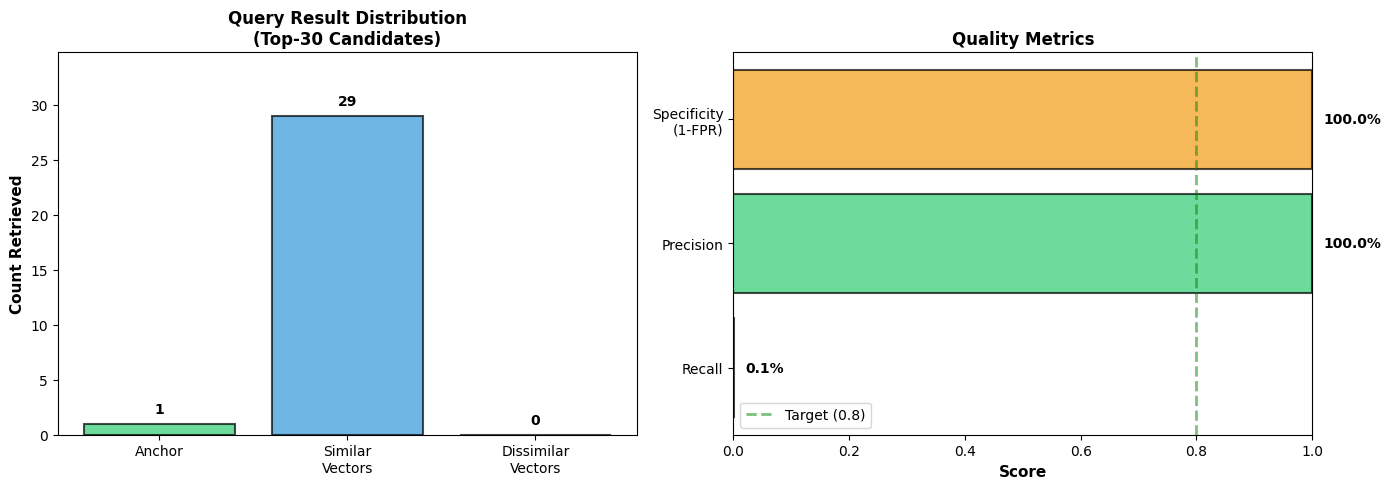

✓ Visualization complete


In [6]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Result Distribution
categories = ['Anchor', 'Similar\nVectors', 'Dissimilar\nVectors']
retrieved = [
    1 if anchor_retrieved else 0,
    similar_retrieved,
    dissimilar_retrieved
]
colors = ['#2ecc71', '#3498db', '#e74c3c']

axes[0].bar(categories, retrieved, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Count Retrieved', fontsize=11, fontweight='bold')
axes[0].set_title('Query Result Distribution\n(Top-30 Candidates)', fontsize=12, fontweight='bold')
axes[0].set_ylim(0, max(retrieved) * 1.2)
for i, v in enumerate(retrieved):
    axes[0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# Plot 2: Metrics Gauge
metrics = ['Recall', 'Precision', 'Specificity\n(1-FPR)']
values = [recall, precision, 1 - fpr]
colors_metrics = ['#3498db', '#2ecc71', '#f39c12']

bars = axes[1].barh(metrics, values, color=colors_metrics, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Score', fontsize=11, fontweight='bold')
axes[1].set_title('Quality Metrics', fontsize=12, fontweight='bold')
axes[1].set_xlim(0, 1)
axes[1].axvline(x=0.8, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Target (0.8)')
axes[1].legend()

for i, (bar, v) in enumerate(zip(bars, values)):
    axes[1].text(v + 0.02, i, f'{v:.1%}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

## Section 7: Advanced - Understanding False Positives

Let's understand WHY we get false positives. It's due to the probabilistic nature of random projections.

In [7]:
# Compute actual cosine similarity for all candidates
from scipy.spatial.distance import cosine

candidate_similarities = []
for cand_id in candidates:
    if cand_id == anchor_id:
        cand_vec = anchor_vector
    elif cand_id in similar_ids:
        cand_vec = similar_vectors[cand_id - 1]
    else:
        cand_vec = dissimilar_vectors[cand_id - num_similar - 1]
    
    # Cosine distance → similarity
    dist = cosine(anchor_vector, cand_vec)
    similarity = 1 - dist  # Convert distance to similarity
    
    is_similar = cand_id in similar_ids or cand_id == anchor_id
    candidate_similarities.append({
        'id': cand_id,
        'similarity': similarity,
        'type': 'Similar' if is_similar else 'Dissimilar'
    })

# Sort by similarity
candidate_similarities.sort(key=lambda x: x['similarity'], reverse=True)

# Print top candidates with actual scores
print("Top Candidates with Actual Cosine Similarity\n")
print("Rank | ID  | Type        | Cosine Similarity | Correct?")
print("-" * 60)

for rank, item in enumerate(candidate_similarities[:15], 1):
    correct = "✓" if item['type'] == 'Similar' else "✗ FP"
    print(f"{rank:4d} | {item['id']:3d} | {item['type']:11s} | {item['similarity']:17.4f} | {correct}")

print(f"\n💡 Observation: False positives occur because random projections")
print(f"   sometimes collide even for unrelated vectors. This is expected!")
print(f"   Re-ranking with exact cosine similarity eliminates these false positives.")

Top Candidates with Actual Cosine Similarity

Rank | ID  | Type        | Cosine Similarity | Correct?
------------------------------------------------------------
   1 |   0 | Similar     |            1.0000 | ✓
   2 | 38065 | Similar     |            0.9955 | ✓
   3 | 261 | Similar     |            0.9954 | ✓
   4 | 27297 | Similar     |            0.9954 | ✓
   5 | 10202 | Similar     |            0.9952 | ✓
   6 | 180 | Similar     |            0.9952 | ✓
   7 |  47 | Similar     |            0.9952 | ✓
   8 | 4728 | Similar     |            0.9951 | ✓
   9 | 33923 | Similar     |            0.9951 | ✓
  10 | 157 | Similar     |            0.9951 | ✓
  11 | 39269 | Similar     |            0.9950 | ✓
  12 | 9824 | Similar     |            0.9949 | ✓
  13 | 42206 | Similar     |            0.9948 | ✓
  14 | 32175 | Similar     |            0.9948 | ✓
  15 | 268 | Similar     |            0.9948 | ✓

💡 Observation: False positives occur because random projections
   sometimes collide 

## Section 8: Clean Up

Clear Redis data for next notebook.

In [9]:
lsh.clear()
print("✓ Demo 1 Complete - Redis cleaned up")

✓ Demo 1 Complete - Redis cleaned up
